### Outline
1. Why vectorization
2. Vectorisation examples
3. Scalar class -recap
4. Class with vectorised weights (first convert weights of scalar class to vector)
5. Class with vectorised weights and inputs (then convert inputs of scalar class to vector too)
6. Exercise

In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import seaborn as sns
import imageio
from IPython.display import HTML

from sklearn.preprocessing import  OneHotEncoder
from sklearn.datasets import make_blobs

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])
np.random.seed(0)

# Generate Data

In [44]:
data, labels = make_blobs(n_samples = 1000, centers = 4, n_features = 2, random_state=0)

print(data.shape, labels.shape)

(1000, 2) (1000,)


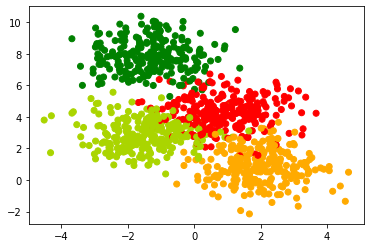

In [45]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap = my_cmap)
plt.show()

# Multi class Classification

In [55]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


In [56]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


Again 2 neurons in first hidden layer and 4 neurons in output layer.

In [48]:
# W1 : 4 weights coming to first layer, 8 weights coming to second layer
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[ 1.23029068  1.20237985]
 [-0.38732682 -0.30230275]]
[[-1.04855297 -1.42001794 -1.70627019  1.9507754 ]
 [-0.50965218 -0.4380743  -1.25279536  0.77749036]]


# Weight Vectorised Version

In [0]:
class FF_MultiClass_WeightVectorised:

  def __init__(self, W1, W2):

    # Deep copy so either doesn't affect each other
    self.W1 = W1.copy()
    self.W2 = W2.copy()

    # B2 contains biases for each neuron of second layer in one variable!
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  # much shorter in vectorised version
  def forward_pass(self, x):
    # Convert to row
    # When playing with vectors i.e. tensors, always keep record of dimensions! Else for higher dimensions, we'll be choosing the wrong matrices to be multiplied

    x = x.reshape(1, -1) # (1, 2) for a single x (record)

    # np.multiply does point-wise multiplication while matmul does row*col (the normal multiplication)
    self.A1 = np.matmul(x, self.W1)+self.B1 # (1,2) * (2,2) = (1,2)
    
    # np.exp getting broadcasted to all elements, thus same vector size returned
    self.H1 = self.sigmoid(self.A1) # (1,2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (1,2) * (2,4) = (1,4)
    
    # Like np.exp, since we have defined sigmoid function, we have used np.sum and np.exp which can support vectorization by performing operation individually on each of them
    self.H2 = self.sigmoid(self.A2) # (1,4)
    return self.H2

  # grad (partial derivative) of sigmoid function
  def grad_sigmoid(self, x):
    return x*(1-x)

  def grad(self, x, y):
    self.forward_pass(x)
    x = x.reshape(1, -1) # (1, 2)
    y = y.reshape(1, -1) # (1, 4)

    # Basically going backwards using the estimated parameters (estimated during forward pass)
    self.dA2 = self.H2 - y # -(y-y') # (1, 4)
    
    self.dW2 = np.matmul(self.H1.T , self.dA2) # (2,1) * (1,4) = (2,4)
    self.dB2 = self.dA2 # (1,4)

    self.dH1 = np.matmul(self.dA2, (self.W2).T) # (1, 4) * (4, 2) = (1,2)
    # Pointwise mulitplication! 
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (1,2) * (1,2) = (1,2)

    self.dW1 = np.matmul(x.T, self.dA1) # (2,1) * (1,2) = (2,2)
    self.dB1 = self.dA1 # (1,2)

    # Note all derivatives have the same dimensions as their original ones

  def fit(self, X, Y, epochs = 1, learning_rate = 1, display_loss = False):
    if display_loss:
      loss = {}

    for i in tqdm_notebook(range(epochs), total = epochs, unit="epoch"):
      dW1 = np.zeros((2,2))
      dW2 = np.zeros((2,4))
      dB1 = np.zeros((1,2))
      dB2 = np.zeros((1,4))

      for x, y in zip(X, Y):
        self.grad(x, y)
        # grad internally calls forward pass as well
        dW1 += self.dW1
        dW2 += self.dW2
        dB1 += self.dB1
        dB2 += self.dB2

      m = X.shape[0]

      self.W1 -= learning_rate * (dW1/m)
      self.W2 -= learning_rate * (dW2/m)
      self.B1 -= learning_rate * (dB1/m)
      self.B2 -= learning_rate * (dB2/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis = 1), Y_pred)

    if(display_loss):
      plt.plot(np.array(list(loss.values())))
      plt.xlabel("Epochs")
      plt.ylabel("Log loss")
      plt.show()

  def predict(self,X):
    Y_pred = []
    for x in X:
      # Once model is trained and you have all the params (wt, b) ready, you will get the predicted answer directly in one forward pass since all wts have been finalised, nothing more to do
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()




  

# Input Weight Vectorised Version

Note that:
X and Y parameters that are passed to the (fit function have the input and output columns respectively. Thus X is nx2 (n records and 2 input features/columns) and Y is nx4 (4 output classes/columns corresponding to each of the n records).  

Previously the for loop in fit function extracted each record in the X and Y as x and y where x was 1x2 and y was 1x4. So passing each record individually and then finding the gradient for each and adding to final gradient.  

This time vectorise even that, i.e. instead of passing one by one, remove the entire for-loop and calculate all at once.

In [0]:
class FF_MultiClass_InputWeightVectorised:

  def __init__(self, W1, W2):

    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  # Note small x to capital X => supporting vector of inputs this time
  def forward_pass(self, X):
    # Also removed the shaping thus
    self.A1 = np.matmul(X, self.W1)+self.B1 # (N,2) * (2,2) = (N,2)
    self.H1 = self.sigmoid(self.A1) # (N,2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (N,2) * (2,4) = (N,4)
    self.H2 = self.sigmoid(self.A2) # (N,4)
    return self.H2

  # capital X here too
  def grad_sigmoid(self, X):
    return X*(1-X)

  # capital X and Y here again (vector)
  def grad(self, X, Y):
    self.forward_pass(X)
   
    # removed the reshaping

    # Basically going backwards using the estimated parameters (estimated during forward pass)
    self.dA2 = self.H2 - Y # -(y-y') # (N, 4) both
    

    # Note that dims of dW1, dW2 remain constant. Not going to depend on number of inputs for these parameters since N is the inner dimension 
    # AND what's happening along the inner dimensions is summation. THUS, the summation that you used to do in the fit function now happens in the matrix multiplication itself
    # Similarly dB1 and dB2 we are summing up all records to get constant dimension regardless of number of input records
    self.dW2 = np.matmul(self.H1.T , self.dA2) # (2,N) * (N,4) = (2,4)
    self.dB2 = self.dA2.copy() # (N,4)
    self.dB2 = np.sum(self.dB2, axis=0).reshape(1,-1) # (1, 4)
    # axis = 0 => across dim = 0 i.e. rows i.e. along col i.e. summing for each record

    self.dH1 = np.matmul(self.dA2, self.W2.T) # (N, 4) * (4, 2) = (N,2)
    # Pointwise mulitplication! 
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (N,2) .* (N,2) = (N,2)

    self.dW1 = np.matmul(X.T, self.dA1) # (2,N) * (N,2) = (2,2)
    self.dB1 = self.dA1.copy() # Deep copy, else even dA1 changes in the next step # (N,2)
    self.dB1 = np.sum(self.dB1, axis = 0).reshape(1, -1) # (1,2)
    # reshaping to 1 row, as many cols as original

    # Note all derivatives have the same dimensions as their original ones

  def fit(self, X, Y, epochs = 1, learning_rate = 1, display_loss = False):
    if display_loss:
      loss = {}

    for i in tqdm_notebook(range(epochs), total = epochs, unit="epoch"):
      # Note the major change
      self.grad(X, Y) # X -> (N,2), Y -> (N,4)

      # grad -> passes the entire vector X to -> forward pass (note dims there) -> 
      
      # No more need to care about vectors since forward pass finishes one epoch (calculating parameters in forward pass and gradients in back prop. Only thing left is to update using the derivatives so far calculated)
      m = X.shape[0]

      # Directly multiply with self.dW1 which already contains the sum of derivatives for all records (unlike dW1 before)
      self.W1 -= learning_rate * (self.dW1/m)
      self.W2 -= learning_rate * (self.dW2/m)
      self.B1 -= learning_rate * (self.dB1/m)
      self.B2 -= learning_rate * (self.dB2/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis = 1), Y_pred)

    if(display_loss):
      plt.plot(np.array(list(loss.values())))
      plt.xlabel("Epochs")
      plt.ylabel("Log loss")
      plt.show()

  def predict(self,X):
    Y_pred = []
    for x in X:
      # Once model is trained and you have all the params (wt, b) ready, you will get the predicted answer directly in one forward pass since all wts have been finalised, nothing more to do
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze() 

# Scalar Version

In [0]:
class FFSN_MultiClassScalar:
  # Using vectors throughout to simplify computations

  def __init__(self): # hidden_sizes, comma separated values of number of neurons in each hidden layer

    self.w1 = np.random.randn()
    self.w2 = np.random.randn()
    self.w3 = np.random.randn()
    self.w4 = np.random.randn()
    self.w5= np.random.randn()
    self.w6 = np.random.randn()
    self.w7 = np.random.randn()
    self.w8 = np.random.randn()
    self.w9 = np.random.randn()
    self.w10 = np.random.randn()
    self.w11 = np.random.randn()
    self.w12 = np.random.randn()
    self.b1 = 0
    self.b2 = 0
    self.b3 = 0
    self.b4 = 0
    self.b5 = 0
    self.b6 = 0

    
  def sigmoid(self,x):
      return 1.0/(1.0+np.exp(-x))

  def forward_pass(self,x):
      # input layer 
      self.x1, self.x2 = x

      # hidden layer
      self.a1 = self.w1*self.x1 + self.w2*self.x2 + self.b1
      self.h1 = self.sigmoid(self.a1)
      self.a2 = self.w3*self.x1 + self.w4*self.x2 + self.b2
      self.h2 = self.sigmoid(self.a2)

      # output layer
      self.a3 = self.w5*self.h1 + self.w6*self.h2 + self.b3
      self.a4 = self.w7*self.h1 + self.w8*self.h2 + self.b3
      self.a5 = self.w9*self.h1 + self.w10*self.h2 + self.b3
      self.a6 = self.w11*self.h1 + self.w12*self.h2 + self.b3

      # Softmax
      sum_exps = np.sum([np.exp(self.a3),np.exp(self.a4),np.exp(self.a5),np.exp(self.a6)])

      self.h3 = np.exp(self.a3)/sum_exps
      self.h4 = np.exp(self.a4)/sum_exps
      self.h5 = np.exp(self.a5)/sum_exps
      self.h6 = np.exp(self.a6)/sum_exps


      # return probability(output) corresponding to each label/class
      return np.array([self.h3,self.h4,self.h5,self.h6])


  def grad(self,x,y):
      self.forward_pass(x)
      # Splittng the actual output (thus getting the "one hot encoding")
      self.y1, self.y2, self.y3, self.y4 = np.array(y)

      # Using self.dw's since they then belong to the class, don't have to return the array of so many parameters (easy way to return)

      # Output layer
      # Chain rule when applied to softmax function so just -(y-y') (not sigmoid unlike binary classification where derivative was y'(1-y'))
      self.dw5 = (self.h3-self.y1)*self.h1 
      self.dw6 = (self.h3-self.y1)*self.h2
      self.db3 = (self.h3-self.y1)

      self.dw7 = (self.h4-self.y2)*self.h1
      self.dw8 = (self.h4-self.y2)*self.h2
      self.db4 = (self.h4-self.y2)

      self.dw9 = (self.h5-self.y3)*self.h1 # x(input) is h1
      self.dw10 = (self.h5-self.y3)*self.h2
      self.db5 = (self.h5-self.y3)

      self.dw11 = (self.h6-self.y4)*self.h1 # x(input) is h1
      self.dw12 = (self.h6-self.y4)*self.h2
      self.db6 = (self.h6-self.y4)

      # First hidden layer
      # This time compute dh1 since h1 depends on many terms (all h3,h4,h5,h6), so apply chain rule to each
      self.dh1 = (self.h3-self.y1)*(self.w5) + (self.h4-self.y2)*(self.w7) + (self.h5-self.y3)*(self.w9) + (self.h6-self.y4)*(self.w11)
      # use dh1 - easier
      self.dw1 = self.dh1*self.h1*(1-self.h1)*self.x1
      self.dw2 = self.dh1*self.h1*(1-self.h1)*self.x2
      self.db1 = self.dh1*self.h1*(1-self.h1)

      self.dh2 = (self.h3-self.y1)*(self.w6) + (self.h4-self.y2)*(self.w8) + (self.h5-self.y3)*(self.w10) + (self.h6-self.y4)*(self.w12)
      self.dw3 = self.dh2*self.h2*(1-self.h2)*self.x1
      self.dw4 = self.dh2*self.h2*(1-self.h2)*self.x2
      self.db2 = self.dh2*self.h2*(1-self.h2)
  

  def fit(self, X, Y, epochs = 1, learning_rate = 1, initialise = True, display_loss = True):

    if display_loss:
      loss = {}

    for i in tqdm_notebook(range(epochs), total = epochs, unit = "epoch"):
      dw1, dw2, dw3, dw4, dw5, dw6, dw7, dw8, dw9, dw10, dw11, dw12, db1, db2, db3, db4, db5, db6 = [0]*18

      for x,y in zip(X,Y):
        self.grad(x,y)
        # accumulating values for each input, i.e. appending to the list for each value
        dw1 += self.dw1
        dw2 += self.dw2
        dw3 += self.dw3
        dw4 += self.dw4
        dw5 += self.dw5
        dw6 += self.dw6
        dw7 += self.dw7
        dw8 += self.dw8
        dw9 += self.dw9
        dw10 += self.dw10
        dw11 += self.dw11
        dw12 += self.dw12
        db1 += self.db1
        db2 += self.db2
        db3 += self.db3
        db4 += self.db4
        db5 += self.db5
        db6 += self.db6



      m = X.shape[1] 

      self.w1 -= learning_rate * dw1 / m
      self.w2 -= learning_rate * dw2 / m
      self.w3 -= learning_rate * dw3 / m
      self.w4 -= learning_rate * dw4 / m
      self.w5 -= learning_rate * dw5 / m
      self.w6 -= learning_rate * dw6 / m
      self.w7 -= learning_rate * dw7 / m
      self.w8 -= learning_rate * dw8 / m
      self.w9 -= learning_rate * dw9 / m
      self.w10 -= learning_rate * dw10 / m
      self.w11 -= learning_rate * dw11 / m
      self.w12 -= learning_rate * dw12 / m
      self.b1 -= learning_rate * db1 / m
      self.b2 -= learning_rate * db2 / m
      self.b3 -= learning_rate * db3 / m
      self.b4 -= learning_rate * db4 / m
      self.b5 -= learning_rate * db5 / m
      self.b6 -= learning_rate * db6 / m

      if(display_loss):
        Y_pred = self.predict(X)
        loss[i] = mean_squared_error(Y, Y_pred)


    if display_loss:
      plt.plot(np.array(list(loss.values())))
      plt.xlabel("Epochs")
      plt.ylabel("Mean Squared Error")
      plt.show()



    # Finally, predict
  def predict(self, X):
      Y_pred = []
      for x in X: 
        y_pred = self.forward_pass(x) # Predict output on each "pair" of inputs (of the two features)
        Y_pred.append(y_pred)
      return np.array(Y_pred)


# Rerun of the three versions 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


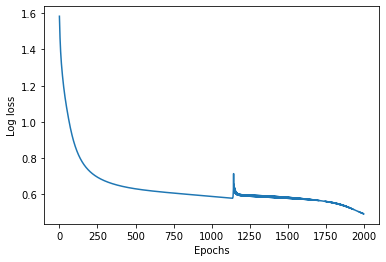

In [116]:
ffsn_multiclass = FF_MultiClass_WeightVectorised(W1, W2)
ffsn_multiclass.fit(X_train, y_OH_train, epochs = 2000, learning_rate = 0.5, display_loss=True)
# Wasn't learning at all. Loss = 1.8 initially and flat decrease. 
# Realised that due to too small learning_rate. So don't give too small (0.001).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


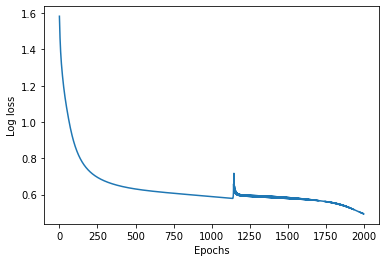

In [117]:
ffsn_multiclass = FF_MultiClass_InputWeightVectorised(W1, W2)
ffsn_multiclass.fit(X_train, y_OH_train, epochs = 2000, learning_rate = 0.5, display_loss=True)
# Wasn't learning at all. Loss = 1.8 initially and flat decrease. 
# Realised that due to too small learning_rate. So don't give too small (0.001).

In [120]:
Y_pred_train = ffsn_multiclass.predict(X_train) # forward pass
Y_pred_train_value = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multiclass.predict(X_val)
Y_pred_val_value = np.argmax(Y_pred_val,1)
                         
accuracy_train = accuracy_score(Y_pred_train_value, Y_train)
accuracy_val = accuracy_score(Y_pred_val_value, Y_val)

# round to two digits
print("Training accuracy", round(accuracy_train,2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.86
Validation accuracy 0.86


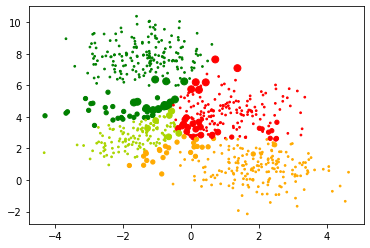

In [122]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train_value, cmap = my_cmap, s = 15*(np.abs(Y_pred_train_value-Y_train)+.2))

### Note that input-weight vectorised model couldn't predict properly only at the intersections. Else really good prediction!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


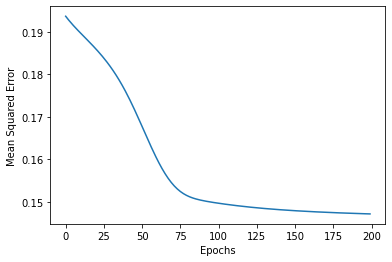

In [77]:
ffsn_multiclass = FFSN_MultiClassScalar()

# Was getting a bad error. Realised had passed Y_train instead of y_OH_train
# Loss significantly reduced on 1000, 0.1 -> 2000, 0.01 . Also note how loss gradually decreases unlike the irregular rise and fall
ffsn_multiclass.fit(X_train, y_OH_train, epochs = 200, learning_rate = 0.001, display_loss=True)

# Comparison of the three versions 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


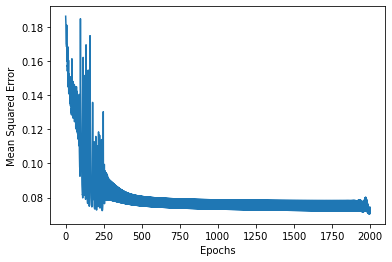

Time taken by model 1 : 185.88987350463867


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


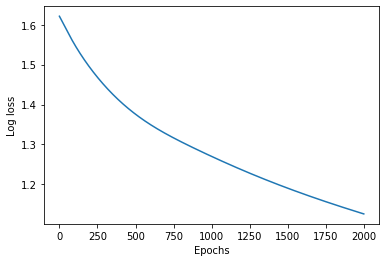

Time taken by model 2 : 68.16367077827454


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


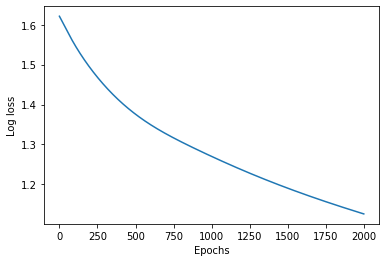

Time taken by model 3 : 24.573914289474487


In [114]:
models_init = [FFSN_MultiClassScalar(), FF_MultiClass_WeightVectorised(W1,W2), FF_MultiClass_InputWeightVectorised(W1,W2)]
models = []

for idx, model in enumerate(models_init, start=1):
  tic = time.time()
  model.fit(X_train, y_OH_train, epochs = 2000, learning_rate = 0.01, display_loss = True)
  models.append(model) # Store the trained model for subsequent use
  toc = time.time()
  print("Time taken by model {} : {}".format(idx, toc-tic))

# Was getting error "Overflow encountered in exp" error several times. Later realised that it was due to the large learning rate. So reduced it.
# So giving both high and low is wrong

### Note the drastic increase in number of epochs per second and the significant decrease in the total time taken as the model is changed from scalar to vector.